In [51]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [52]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

np.random.seed(1234)

CUDA


In [53]:
# Deep neural network
# class DNN(torch.nn.Module):
#     def __init__(self, layers):
#         super(DNN, self).__init__()
        
#         # parameters
#         self.depth = len(layers) - 1
        
#         # set up layer order dict
#         self.activation = torch.nn.Tanh
        
#         layer_list = list()
#         for i in range(self.depth - 1): 
#             layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
#             layer_list.append(('activation_%d' % i, self.activation()))
#         layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
#         layerDict = OrderedDict(layer_list)
        
#         # deploy layers
#         self.layers = torch.nn.Sequential(layerDict)
        
#     def forward(self, x):
#         out = self.layers(x)
#         return out

class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [85]:
class PINN():
    def __init__(self, X, layers, u_bc, u_x_bc, E, I, F, L):
        
        self.x = torch.tensor(X["Domain"], requires_grad=True).float().to(device)
        self.x_bc = torch.tensor(X["BC"], dtype=torch.float32, requires_grad=True).to(device)
        self.u_bc = torch.tensor(u_bc).float().to(device)
        self.u_x_bc = torch.tensor(u_x_bc).float().to(device)

        self.E = E
        self.I = I
        self.F = F
        self.L = L

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lfbgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0

    def net_u(self, x):
        u = self.dnn(x)
        return u

    def pde_loss(self, x):
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        lhs = self.E * self.I * u_xx
        rhs = -self.F * (self.L - x)
        residual = lhs - rhs
        return torch.mean(residual**2)
    
    def boundary_loss(self, x_bc, u_exact, u_x_exact):
        u_pred = self.net_u(x_bc)
        u_x_pred = torch.autograd.grad(u_pred, x_bc, torch.ones_like(u_pred), create_graph=True)[0]
        boundary = (u_pred - u_exact) + (u_x_pred - u_x_exact)
        return torch.mean(boundary**2)
    
    def loss_func(self):
        loss = self.pde_loss(self.x) + self.boundary_loss(self.x_bc, self.u_bc, self.u_x_bc)

        self.optimizer_lfbgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {loss.item():.6f}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.pde_loss(self.x) + 2*self.boundary_loss(self.x_bc, self.u_bc, self.u_x_bc)

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

        self.optimizer_lfbgs.step(self.loss_func)

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x)
        u = u.detach().cpu().numpy()
        return u

In [55]:
def exact_solution(x, E, I, F, L):
    a = F/(6*E*I)
    b = (x**3 - 3*L*x**2)
    return a*b

In [86]:
E = 1.0
I = 1.0
F = 1.0
L = 1.0

x = np.linspace(0, L, 1000)
u_exact = exact_solution(x, E, I, F, L)

layers = [1, 20, 20, 20, 1]

x_domain = np.random.choice(x, 100).reshape(-1, 1)
x_bc = np.array([0.0])
u_bc = np.array([0.0])
u_x_bc = np.array([0.0])

x_train = {"Domain": x_domain, "BC": x_bc}

model = PINN(x_train, layers, u_bc, u_x_bc, E, I, F, L)
model.train(5000)


Epoch 0, Loss: 0.529697
Epoch 100, Loss: 0.000809
Epoch 200, Loss: 0.000368
Epoch 300, Loss: 0.000316
Epoch 400, Loss: 0.000277
Epoch 500, Loss: 0.000248
Epoch 600, Loss: 0.000225
Epoch 700, Loss: 0.000205
Epoch 800, Loss: 0.000188
Epoch 900, Loss: 0.000171
Epoch 1000, Loss: 0.000155
Epoch 1100, Loss: 0.000140
Epoch 1200, Loss: 0.000125
Epoch 1300, Loss: 0.000111
Epoch 1400, Loss: 0.000097
Epoch 1500, Loss: 0.000084
Epoch 1600, Loss: 0.000071
Epoch 1700, Loss: 0.000059
Epoch 1800, Loss: 0.000048
Epoch 1900, Loss: 0.000038
Epoch 2000, Loss: 0.000029
Epoch 2100, Loss: 0.000021
Epoch 2200, Loss: 0.000015
Epoch 2300, Loss: 0.000010
Epoch 2400, Loss: 0.000007
Epoch 2500, Loss: 0.000005
Epoch 2600, Loss: 0.000003
Epoch 2700, Loss: 0.000013
Epoch 2800, Loss: 0.000002
Epoch 2900, Loss: 0.000002
Epoch 3000, Loss: 0.000002
Epoch 3100, Loss: 0.000002
Epoch 3200, Loss: 0.000002
Epoch 3300, Loss: 0.000001
Epoch 3400, Loss: 0.000002
Epoch 3500, Loss: 0.000001
Epoch 3600, Loss: 0.000026
Epoch 3700, L

L2 Error: 1.790157498905863


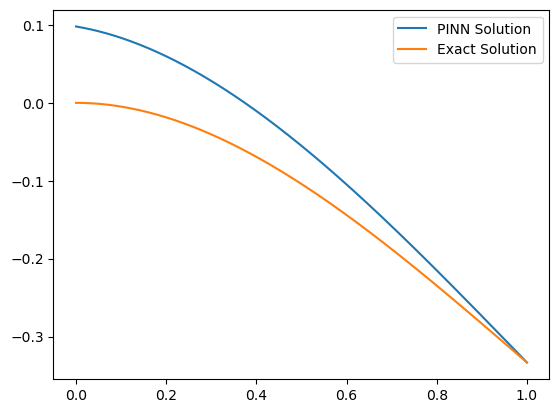

In [88]:
x1 = np.linspace(0,L,1000).reshape(-1, 1)
u_pred = model.predict(x1)
lst = u_pred.flatten().tolist()

l2_error = np.linalg.norm(lst - u_exact)
print(f"L2 Error: {l2_error}")

plt.plot(x1, lst, label="PINN Solution")
plt.plot(x, u_exact, label="Exact Solution")
plt.legend()
plt.show()